In [ ]:
# Step 1: Mount Google Drive and Load Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
# Load the dataset
train = pd.read_csv("/content/drive/My Drive/Dataset/train.csv")
test = pd.read_csv("/content/drive/My Drive/Dataset/test.csv")

In [ ]:
# Rename columns
train.columns = ["label", "title", "text"]
test.columns = ["label", "title", "text"]

In [ ]:
# Estimate memory usage
print("Train dataset memory usage:", train.memory_usage(deep=True).sum() / (1024**2), "MB")
print("Test dataset memory usage:", test.memory_usage(deep=True).sum() / (1024**2), "MB")

Train dataset memory usage: 1894.5975503921509 MB
Test dataset memory usage: 210.42834758758545 MB


In [ ]:
from sklearn.utils import resample

In [ ]:
# # Downsample if necessary and Resample to balance the dataset
train_positive = train[train['label'] == 2]
train_negative = train[train['label'] == 1]

train_positive_sampled = resample(train_positive, replace=False, n_samples=5000, random_state=42)
train_negative_sampled = resample(train_negative, replace=False, n_samples=5000, random_state=42)

train_sampled = pd.concat([train_positive_sampled, train_negative_sampled])
train_sampled = train_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
test_sampled = test.sample(n=2000, random_state=42)

In [ ]:
# Verify the new memory usage
print("Sampled train dataset memory usage:", train_sampled.memory_usage(deep=True).sum() / (1024**2), "MB")
print("Sampled test dataset memory usage:", test_sampled.memory_usage(deep=True).sum() / (1024**2), "MB")

Sampled train dataset memory usage: 5.259720802307129 MB
Sampled test dataset memory usage: 1.0783166885375977 MB


In [ ]:
train_sampled.value_counts('label')

,count
label,
1,5000
2,5000


In [ ]:
# Step 2: Data Preprocessing
import re
import string
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.utils import resample

In [ ]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [42]:
def clean_text(text):
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    return text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        if token.lower() not in stopwords.words('english'):
            wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN
            lemmatized_tokens.append(WordNetLemmatizer().lemmatize(token, pos=wordnet_pos))
    return " ".join(lemmatized_tokens)

In [43]:
# Apply text cleaning, stop words removal, and lemmatization
train_sampled['title'] = train_sampled['title'].astype(str).apply(clean_text).apply(lemmatize_text)
test_sampled['title'] = test_sampled['title'].astype(str).apply(clean_text).apply(lemmatize_text)
train_sampled['text'] = train_sampled['text'].astype(str).apply(clean_text).apply(lemmatize_text)
test_sampled['text'] = test_sampled['text'].astype(str).apply(clean_text).apply(lemmatize_text)


In [52]:
# Combine title and text
train_sampled['combined'] = train_sampled['title'] + " " + train_sampled['text']
test_sampled['combined'] = test_sampled['title'] + " " + test_sampled['text']

In [53]:
# Map labels
train_sampled['label'] = train_sampled['label'].map({1: 0, 2: 1})
test_sampled['label'] = test_sampled['label'].map({1: 0, 2: 1})

In [54]:
# Step 3: Feature Engineering with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_sampled['combined'])
X_test_tfidf = tfidf_vectorizer.transform(test_sampled['combined'])

In [55]:
# Step 4: Model Training and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
logreg_model = LogisticRegression(max_iter=200)
logreg_model.fit(X_train_tfidf, train_sampled['label'])
y_pred_logreg = logreg_model.predict(X_test_tfidf)
print("Logistic Regression Classification Report:")
print(classification_report(test_sampled['label'], y_pred_logreg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1005
           1       0.85      0.86      0.85       995

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [56]:
# Step 5: Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_tfidf, train_sampled['label'])
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...............................C=0.1, kernel=linear; total time=  24.7s
[CV] END ...............................C=0.1, kernel=linear; total time=  29.8s
[CV] END ...............................C=0.1, kernel=linear; total time=  26.9s
[CV] END ...............................C=0.1, kernel=linear; total time=  24.3s
[CV] END ...............................C=0.1, kernel=linear; total time=  24.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=  30.6s
[CV] END ..................................C=0.1, kernel=rbf; total time=  30.6s
[CV] END ..................................C=0.1, kernel=rbf; total time=  30.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=  30.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  30.5s
[CV] END .................................C=1, kernel=linear; total time=  16.2s
[CV] END .................................C=1, ke

In [57]:
# Step 6: Final Model Training and Evaluation
best_svm_model = SVC(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
best_svm_model.fit(X_train_tfidf, train_sampled['label'])
y_pred_svm = best_svm_model.predict(X_test_tfidf)
print("SVM Classification Report:")
print(classification_report(test_sampled['label'], y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1005
           1       0.85      0.87      0.86       995

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [58]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, train_sampled['label'])
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Classification Report:")
print(classification_report(test_sampled['label'], y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1005
           1       0.83      0.82      0.83       995

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [59]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_tfidf, train_sampled['label'])
y_pred_gb = gb_model.predict(X_test_tfidf)
print("Gradient Boosting Classification Report:")
print(classification_report(test_sampled['label'], y_pred_gb))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80      1005
           1       0.81      0.75      0.78       995

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



In [60]:
# Ensemble Model
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('lr', logreg_model),
    ('svm', best_svm_model),
    ('rf', rf_model),
    ('gb', gb_model)
], voting='hard')

voting_clf.fit(X_train_tfidf, train_sampled['label'])
y_pred_voting = voting_clf.predict(X_test_tfidf)
print("Voting Classifier Classification Report:")
print(classification_report(test_sampled['label'], y_pred_voting))

Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1005
           1       0.87      0.80      0.83       995

    accuracy                           0.84      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [64]:
# Save the final model
import joblib
joblib.dump(voting_clf, '/content/drive/My Drive/Dataset/voting_clf_model.pkl')
joblib.dump(tfidf_vectorizer, '/content/drive/My Drive/Dataset/tfidf_vectorizer.pkl')
joblib.dump(best_svm_model, '/content/drive/My Drive/Dataset/best_svm_model.pkl')

['/content/drive/My Drive/Dataset/best_svm_model.pkl']

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

# Function to visualize results
POSITIVE_LABEL = 1
NEGATIVE_LABEL = 0

def visualize_results(y_test, y_pred, model_name):
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train_tfidf, train_sampled['label'])
y_pred_ada = ada_model.predict(X_test_tfidf)
print("AdaBoost Classification Report:")
print(classification_report(test_sampled['label'], y_pred_ada))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1005
           1       0.82      0.78      0.80       995

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



In [66]:
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model.fit(X_train_tfidf, train_sampled['label'])
y_pred_et = et_model.predict(X_test_tfidf)
print("Extra Trees Classification Report:")
print(classification_report(test_sampled['label'], y_pred_et))

Extra Trees Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1005
           1       0.85      0.82      0.83       995

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [67]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_tfidf, train_sampled['label'])
y_pred_xgb = xgb_model.predict(X_test_tfidf)
print("XGBoost Classification Report:")
print(classification_report(test_sampled['label'], y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1005
           1       0.82      0.82      0.82       995

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [70]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.8 MB/s eta 0:00:00


In [71]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)
cat_model.fit(X_train_tfidf, train_sampled['label'])
y_pred_cat = cat_model.predict(X_test_tfidf)
print("CatBoost Classification Report:")
print(classification_report(test_sampled['label'], y_pred_cat))

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1005
           1       0.82      0.82      0.82       995

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [73]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:00:00


In [74]:
from skopt import BayesSearchCV

# Example for Random Forest
param_space = {
    'n_estimators': (50, 200),
    'max_depth': (10, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

bayes_search = BayesSearchCV(estimator=RandomForestClassifier(random_state=42), search_spaces=param_space, n_iter=32, cv=3, random_state=42, verbose=2)
bayes_search.fit(X_train_tfidf, train_sampled['label'])
print("Best Parameters:", bayes_search.best_params_)
print("Best Score:", bayes_search.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=9, n_estimators=97; total time=   1.9s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=9, n_estimators=97; total time=   2.6s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=9, n_estimators=97; total time=   3.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=27, min_samples_leaf=4, min_samples_split=4, n_estimators=193; total time=   5.0s
[CV] END max_depth=27, min_samples_leaf=4, min_samples_split=4, n_estimators=193; total time=   6.8s
[CV] END max_depth=27, min_samples_leaf=4, min_samples_split=4, n_estimators=193; total time=   7.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=19, min_samples_leaf=4, min_samples_split=3, n_estimators=115; total time=   2.4s
[CV] END max_depth=19, min_samples_leaf=4, min_samples_split=3, n_estimators=115; total time=   2.4s
[CV] END max_depth

In [75]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Initialize the Multinomial Naive Bayes classifier
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train_tfidf, train_sampled['label'])

# Predict on the test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# Print the classification report
print("Multinomial Naive Bayes Classification Report:")
print(classification_report(test_sampled['label'], y_pred_nb))

Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1005
           1       0.82      0.84      0.83       995

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



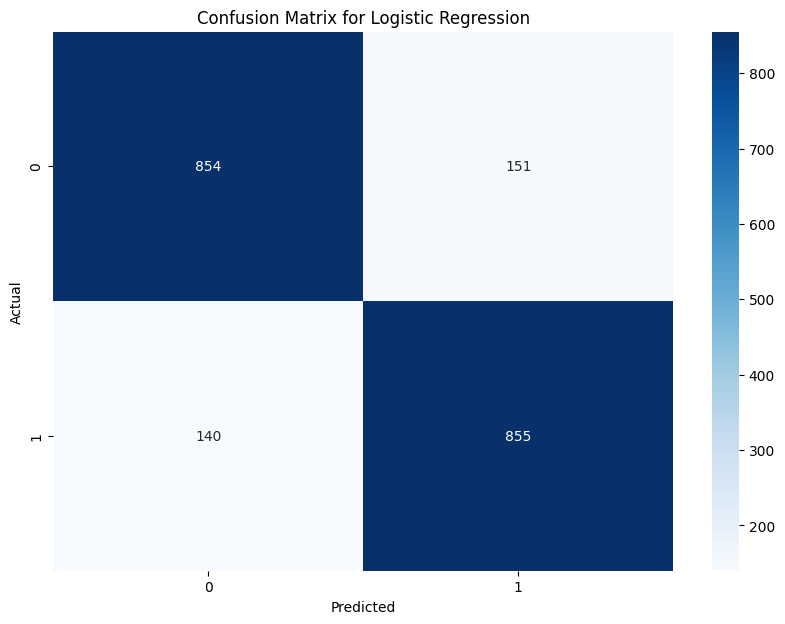

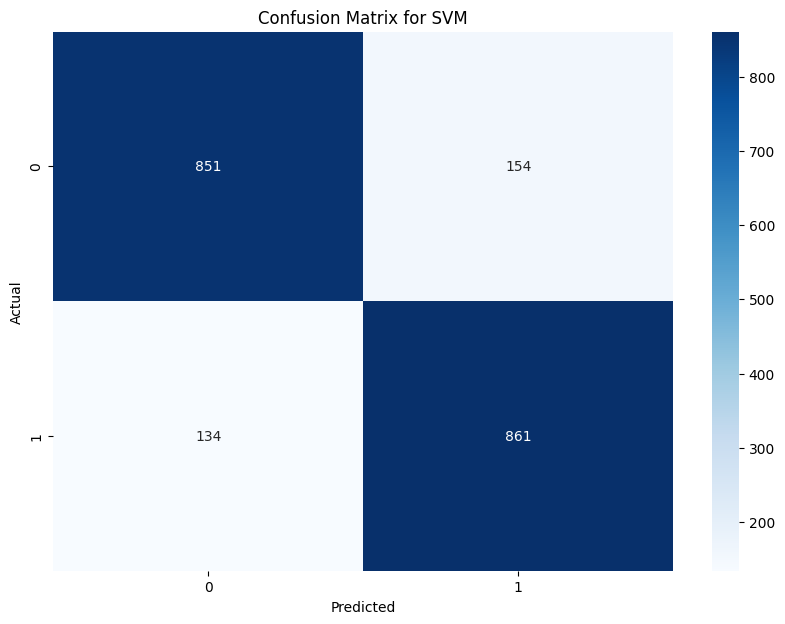

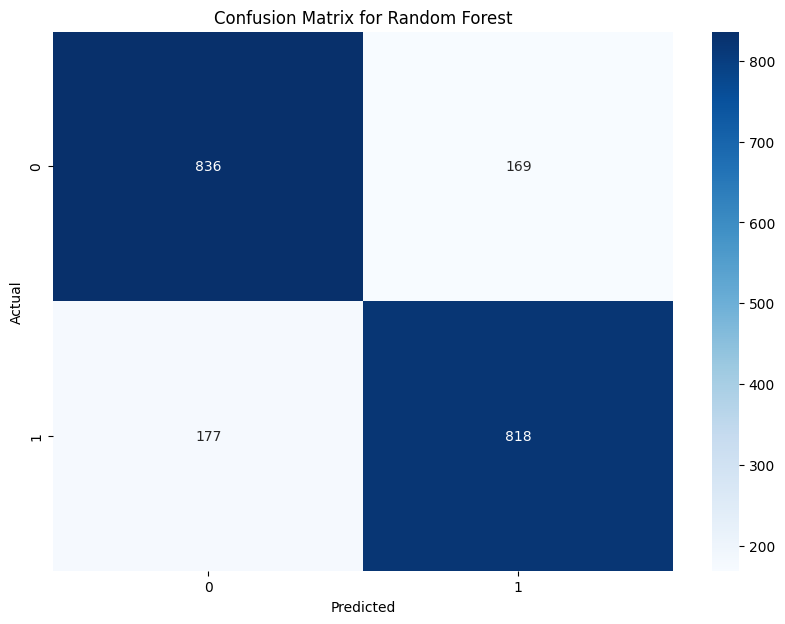

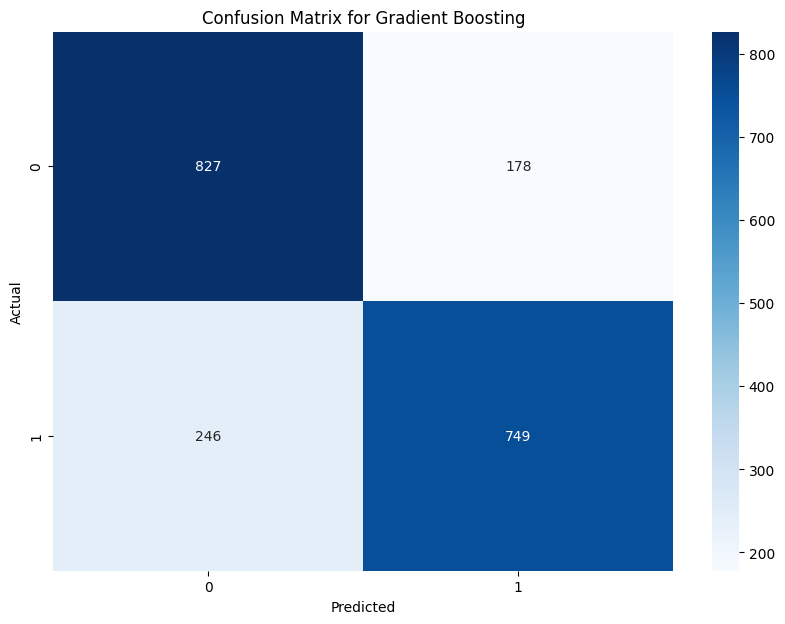

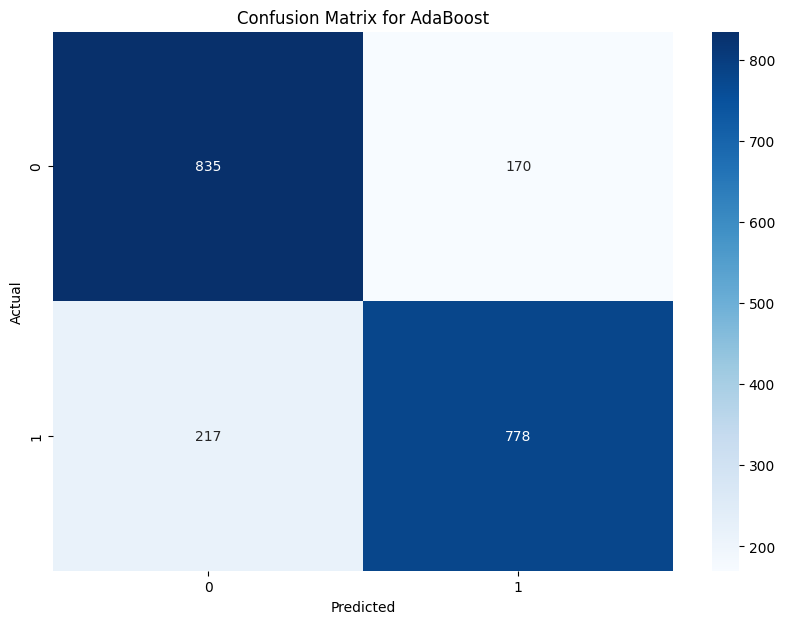

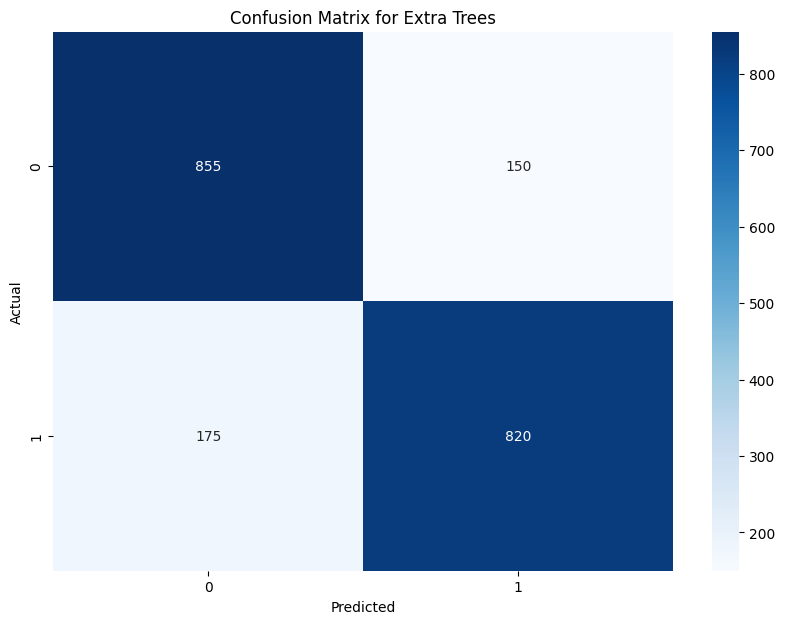

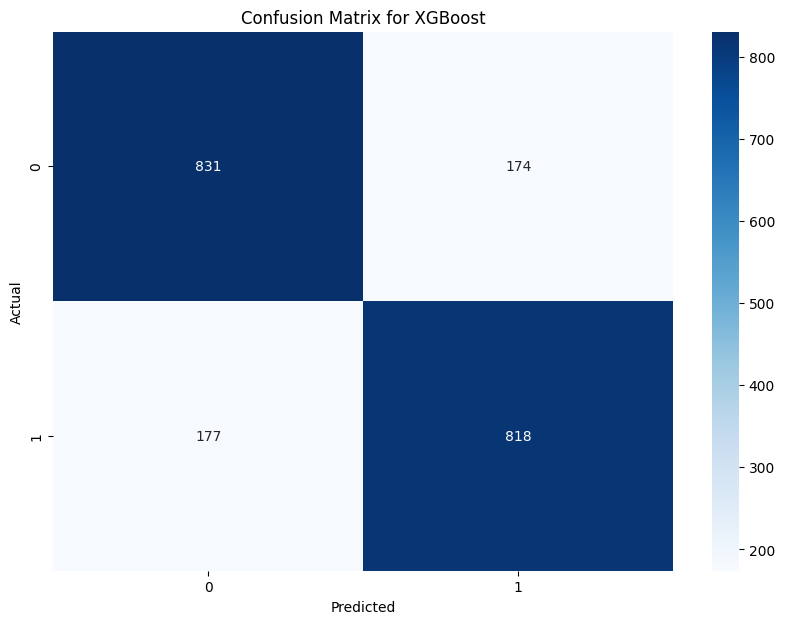

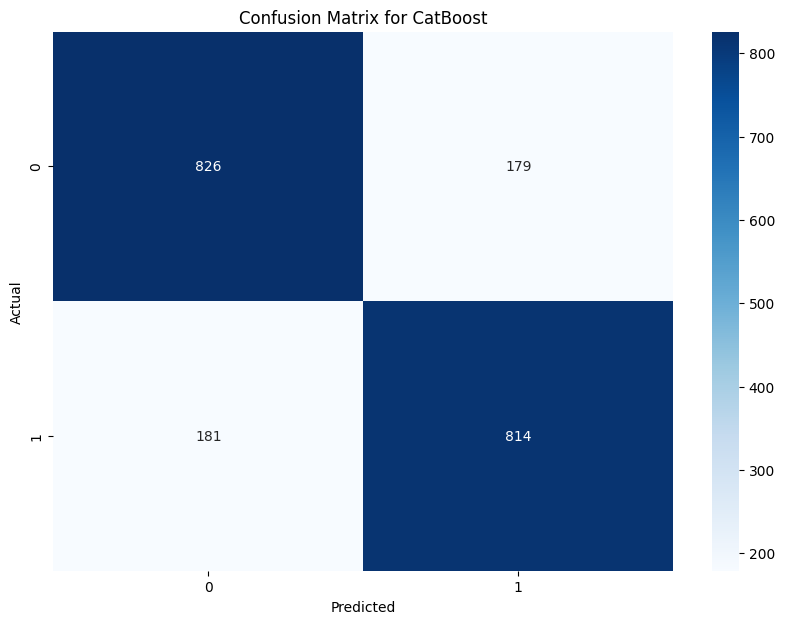

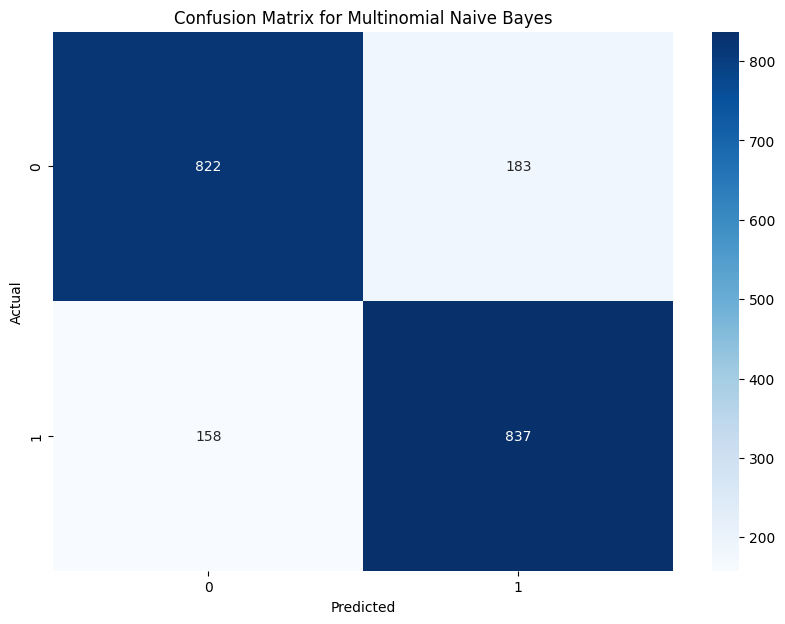

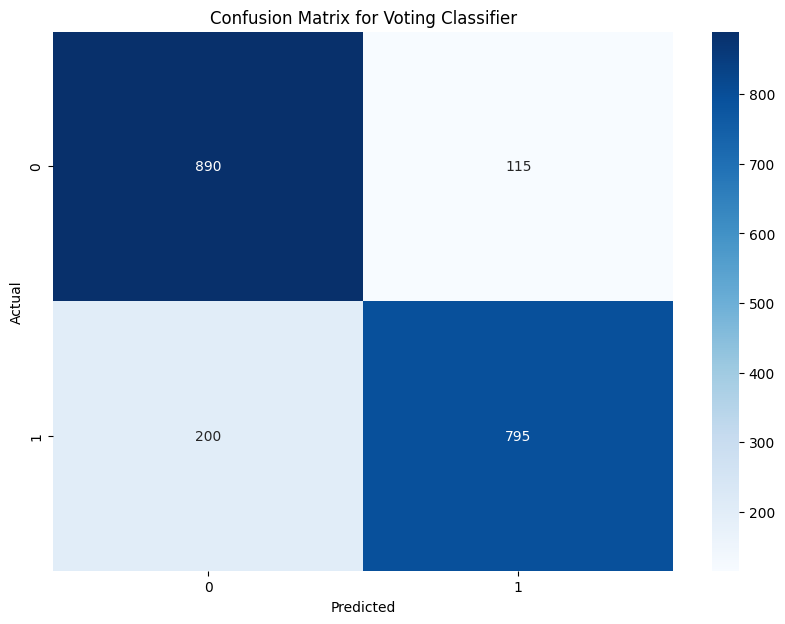

In [77]:
# Visualize results for each model
visualize_results(test_sampled['label'], y_pred_logreg, "Logistic Regression")
visualize_results(test_sampled['label'], y_pred_svm, "SVM")
visualize_results(test_sampled['label'], y_pred_rf, "Random Forest")
visualize_results(test_sampled['label'], y_pred_gb, "Gradient Boosting")
visualize_results(test_sampled['label'], y_pred_ada, "AdaBoost")
visualize_results(test_sampled['label'], y_pred_et, "Extra Trees")
visualize_results(test_sampled['label'], y_pred_xgb, "XGBoost")
visualize_results(test_sampled['label'], y_pred_cat, "CatBoost")
visualize_results(test_sampled['label'], y_pred_nb, "Multinomial Naive Bayes")
visualize_results(test_sampled['label'], y_pred_voting, "Voting Classifier")

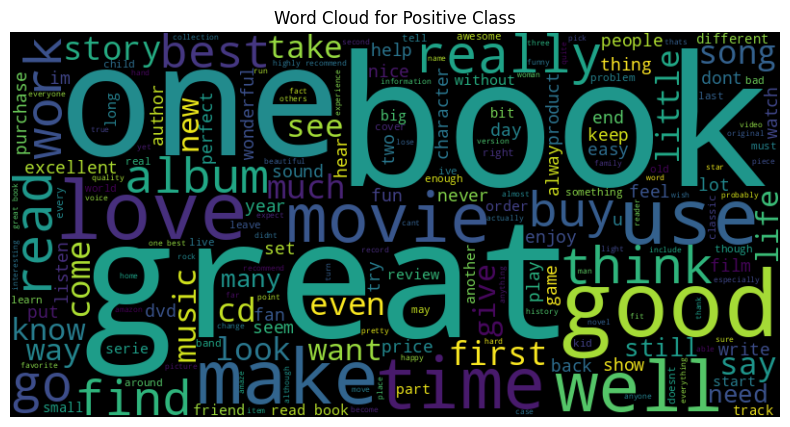

In [78]:
    # Word Cloud for Positive Class
    positive_text = ' '.join(train_sampled[train_sampled['label'] == POSITIVE_LABEL]['combined'])
    wordcloud = WordCloud(width=800, height=400).generate(positive_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for Positive Class')
    plt.axis('off')
    plt.show()

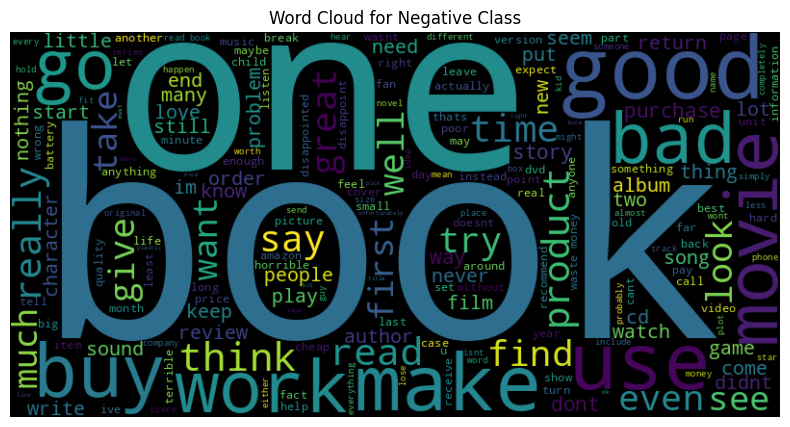

In [79]:
    # Word Cloud for Negative Class
    negative_text = ' '.join(train_sampled[train_sampled['label'] == NEGATIVE_LABEL]['combined'])
    wordcloud = WordCloud(width=800, height=400).generate(negative_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for Negative Class')
    plt.axis('off')
    plt.show()